In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#random seed to replicate
np.random.seed(42)

In [2]:
#Nodes in the graph are defined as two arrays with the respective coordenates (x array and y array)

#Create a instance of metric TSP
def create_instance(n):
    x = np.random.rand(n)
    y = np.random.rand(n)
    
    return x, y

In [3]:
#The follow dict allows fast access to nodes in the graph.
def init_index_map(size):
    neighMap = {}

    for i in range(size):
        neighMap.update({i : i})

    return neighMap

#The sequence array saves the current Hamiltonian Cycle
def init_sequence_array(size):
    sequence = np.arange(size, dtype=np.int32)

    return sequence


In [4]:
#Compute euclidean distance
def compute_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1- y2)**2) 

In [5]:
def path_cost(x, y, seq):
    cost = 0
    size = len(seq) 
    for i in range(size):
        curr = i
        next = (i + 1) % size

        x1 = x[seq[curr]]
        y1 = y[seq[curr]]

        x2 = x[seq[next]]
        y2 = y[seq[next]]

        cost += compute_distance(x1, y1, x2, y2)
    
    return cost

In [6]:
#Return the sum of all edges from the node
def remove_node(seq, nodeIdx, x, y):
    val = 0
    size = len(x)

    node = seq[nodeIdx]
    x1 = x[node]
    y1 = y[node]

    nodeAIdx = (nodeIdx + 1) % size 
    neighborA = seq[nodeAIdx]
    x2 = x[neighborA]
    y2 = y[neighborA]
    val += compute_distance(x1, y1, x2, y2)

    nodeBIdx = (nodeIdx - 1) % size 
    neighborB = seq[nodeBIdx]
    x2 = x[neighborB]
    y2 = y[neighborB]
    val += compute_distance(x1, y1, x2, y2)

    return val

In [7]:
def propose_changes(seq, idx_dict, num_changes, x, y, cost, t):
    size = len(seq)
    nodes = np.random.choice(size, size=int(num_changes), replace=False)
    
    #realDist = path_cost(x, y, seq)

    subtracted_cost = 0
    added_cost      = 0

    i = 0
    while(i < num_changes):
        nodeA = nodes[i]
        nodeB = nodes[i + 1]

        idxA = idx_dict[nodeA]
        idxB = idx_dict[nodeB]

        subtracted_cost += remove_node(seq, idxA, x, y)
        subtracted_cost += remove_node(seq, idxB, x, y)

        #Whether the nodes are neighbors, the edge between them was added two times in "remove_node".
        minIdx = min(idxA, idxB)
        maxIdx = max(idxA, idxB)
        if(maxIdx - minIdx == 1 or (minIdx - maxIdx) % size == 1):
            x1 = x[nodeA]
            y1 = y[nodeA]
            x2 = x[nodeB]
            y2 = y[nodeB]
            dist = compute_distance(x1, y1, x2, y2)
            subtracted_cost -= dist
            added_cost += dist

        neighborA_idx = (idxA - 1) % size
        neighborA = seq[neighborA_idx]
        neighborB_idx = (idxA + 1) % size
        neighborB = seq[neighborB_idx]

        x1 = x[nodeB]
        y1 = y[nodeB]
        x2 = x[neighborA]
        y2 = y[neighborA]
        added_cost += compute_distance(x1, y1, x2, y2)
        x2 = x[neighborB]
        y2 = y[neighborB]
        added_cost += compute_distance(x1, y1, x2, y2)

        neighborA_idx = (idxB - 1) % size
        neighborA = seq[neighborA_idx]
        neighborB_idx = (idxB + 1) % size
        neighborB = seq[neighborB_idx]
        x1 = x[nodeA]
        y1 = y[nodeA]
        x2 = x[neighborA]
        y2 = y[neighborA]
        added_cost += compute_distance(x1, y1, x2, y2)
        x2 = x[neighborB]
        y2 = y[neighborB]
        added_cost += compute_distance(x1, y1, x2, y2)

        i += 2

    de = added_cost - subtracted_cost
    eps = 0.000005
    
    if de <= eps and de > 0:
        de = 0
    
    accept = False
    coin = 0
    val = 0
    
    if de != 0:
        
        if de < 0 :
            accept = True
        
        den = de/t

        if(den == 0):
            den = np.inf()

        val = 1 / np.exp(den)
        coin = np.random.random()

        #If the new path is accepted, switch nodes
        if(accept or coin < val):
            #print("Aceitou uma mudanca")
            i = 0
            cost += de
            while(i < num_changes):
                nodeA = nodes[i]
                nodeB = nodes[i + 1]
                idxA = idx_dict[nodeA]
                idxB = idx_dict[nodeB]

                seq[idxA] = nodeB
                idx_dict[nodeB] = idxA
                seq[idxB] = nodeA
                idx_dict[nodeA] = idxB

                i += 2
            
    return cost

In [8]:
def metropolis(x, y, seq, neighbors_dict, ti, tf, dt):
    cost = path_cost(x, y, seq)
    size = len(seq)
    
    t = ti
    
    #Calculate the number of iterations
    num_it = int(np.ceil((np.log(tf) - np.log(ti)) / np.log(dt)))
        
    result_by_it = np.zeros(num_it, dtype=np.float32)
    all_results = np.zeros(num_it * 100, dtype=np.float32)
    
    i = 0
    j = 0
    while(t > tf):
        for _ in range(100):
            #Select the number of changes accord to a normal dist with mean = size/2 and std = size/4
            #changes = int(np.floor(np.random.normal(size / 2, size/8)))
            
            #Set the number of changes as 1
            changes = 1

            if(changes <= 0):
                changes = 1

            elif(changes > 0.7 * size):
                changes = np.ceil(0.7 * size)

            if(changes % 2 == 1):
                changes += 1

            cost = propose_changes(seq, neighbors_dict, changes, x, y, cost, t, )
            
            all_results[j] = cost
            j += 1
            
        result_by_it[i] = cost
        
        i += 1
        t = t * dt
        
    return result_by_it, all_results

In [9]:
def simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x, y, seq, neighbors_dict):
    #Comments to rememember all parameters
    #ti_arr = [1, 5, 10]
    #tf_arr = [0.005, 0.0001]
    #dt_arr = [0.8, 0.9, 0.99]
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.005, dt=0.8)
    ti_it_results.append(results_by_it)
    ti_all_results.append(all_results)

    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=5, tf = 0.005, dt=0.8)
    ti_it_results.append(results_by_it)
    ti_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=10, tf = 0.005, dt=0.8)
    ti_it_results.append(results_by_it)
    ti_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.005, dt=0.8)
    tf_it_results.append(results_by_it)
    tf_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.0001, dt=0.8)
    tf_it_results.append(results_by_it)
    tf_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.005, dt=0.8)
    dt_it_results.append(results_by_it)
    dt_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.005, dt=0.9)
    dt_it_results.append(results_by_it)
    dt_all_results.append(all_results)
    
    results_by_it, all_results = metropolis(x.copy(), y.copy(), seq.copy(), neighbors_dict.copy(), ti=1, tf = 0.005, dt=0.99)
    dt_it_results.append(results_by_it)
    dt_all_results.append(all_results)
                

In [24]:
def print_charts(mode, instance_siz, results):
    
    if mode == "ti_it":
        
        y1 = results[0]
        y2 = results[1]
        y3 = results[2]
        
        x = np.arange(1, max(len(y1), len(y2), len(y3)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='ti = 1')
        plt.plot(x[:len(y2)], y2, label='ti = 5')
        plt.plot(x[:len(y3)], y3, label='ti = 10')
        
        plt.legend()
        plt.xlabel('Iteracoes')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando Ti - Instancia de {instance_siz} cidades')
                
    elif mode == "tf_it":
        y1 = results[0]
        y2 = results[1]
        
        x = np.arange(1, max(len(y1), len(y2)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='tf = 0.005')
        plt.plot(x[:len(y2)], y2, label='tf = 0.0001')
        
        plt.legend()
        plt.xlabel('Iteracoes')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando Tf - Instancia de {instance_siz} cidades')
                
    elif mode == "dt_it":
        y1 = results[0]
        y2 = results[1]
        y3 = results[2]
        
        x = np.arange(1, max(len(y1), len(y2), len(y3)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='dt = 0.8')
        plt.plot(x[:len(y2)], y2, label='dt = 0.9')
        plt.plot(x[:len(y3)], y3, label='dt = 0.99')
        
        plt.legend()
        plt.xlabel('Iteracoes')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando dt - Instancia de {instance_siz} cidades')
        
    elif mode == "ti_all":
        y1 = results[0]
        y2 = results[1]
        y3 = results[2]
        
        x = np.arange(1, max(len(y1), len(y2), len(y3)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='ti = 1')
        plt.plot(x[:len(y2)], y2, label='ti = 5')
        plt.plot(x[:len(y3)], y3, label='ti = 10')
        
        plt.legend()
        plt.xlabel('Passo Monte Carlo')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando Ti - Instancia de {instance_siz} cidades')
    
    elif mode == "tf_all":
        y1 = results[0]
        y2 = results[1]
        
        x = np.arange(1, max(len(y1), len(y2)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='tf = 0.005')
        plt.plot(x[:len(y2)], y2, label='tf = 0.0001')
        
        plt.legend()
        plt.xlabel('Passos Monte Carlo')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando Tf - Instancia de {instance_siz} cidades')
        
    elif mode == "dt_all":
        y1 = results[0]
        y2 = results[1]
        y3 = results[2]
        
        x = np.arange(1, max(len(y1), len(y2), len(y3)) + 1)
        
        plt.plot(x[:len(y1)], y1, label='dt = 0.8')
        plt.plot(x[:len(y2)], y2, label='dt = 0.9')
        plt.plot(x[:len(y3)], y3, label='dt = 0.99')
        
        plt.legend()
        plt.xlabel('Passos Monte Carlo')
        plt.ylabel('Valor caminho')
        plt.title(f'Variando dt - Instancia de {instance_siz} cidades')

In [11]:
def clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results):
    ti_it_results.clear()
    ti_all_results.clear()
    tf_it_results.clear()
    tf_all_results.clear()
    dt_it_results.clear()
    dt_all_results.clear()

In [12]:
#Creating all instances (ranging from 10 to 150)
x10, y10 = create_instance(10)
x30, y30 = create_instance(30)
x50, y50 = create_instance(50)
x70, y70 = create_instance(70)
x100, y100 = create_instance(100)
x150, y150 = create_instance(150)

#Creating the neighbors maps and seq arrays
idx_dict_10 = init_index_map(10)
idx_dict_30 = init_index_map(30)
idx_dict_50 = init_index_map(50)
idx_dict_70 = init_index_map(70)
idx_dict_100 = init_index_map(100)
idx_dict_150 = init_index_map(150)

seq10 = init_sequence_array(10)
seq30 = init_sequence_array(30)
seq50 = init_sequence_array(50)
seq70 = init_sequence_array(70)
seq100 = init_sequence_array(100)
seq150 = init_sequence_array(150)

#Simulating
ti_it_results = []
ti_all_results = []

tf_it_results = []
tf_all_results = []

dt_it_results = []
dt_all_results = []

In [13]:
#Simulating the size-10 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x10, y10, seq10, idx_dict_10)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)


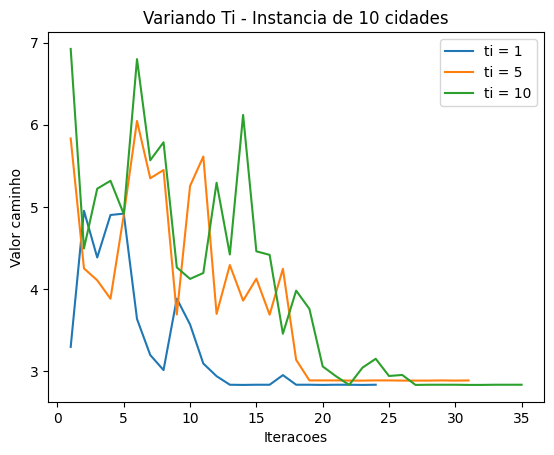

In [14]:
print_charts(mode="ti_it", instance_siz=10, results=ti_it_results)

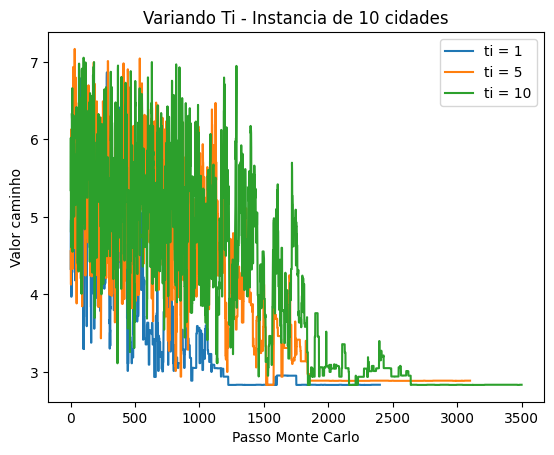

In [15]:
print_charts(mode="ti_all", instance_siz=10, results=ti_all_results)

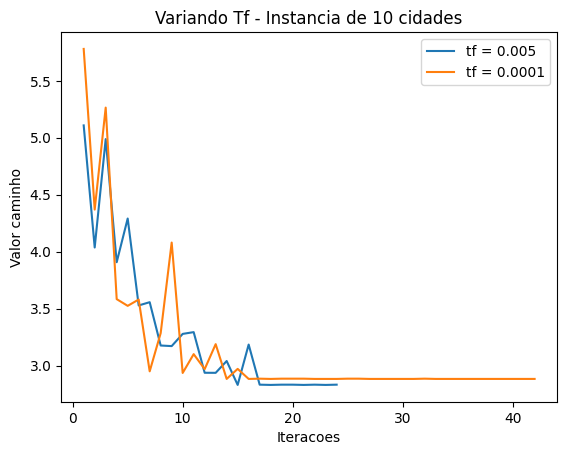

In [18]:
print_charts(mode="tf_it", instance_siz=10, results=tf_it_results)


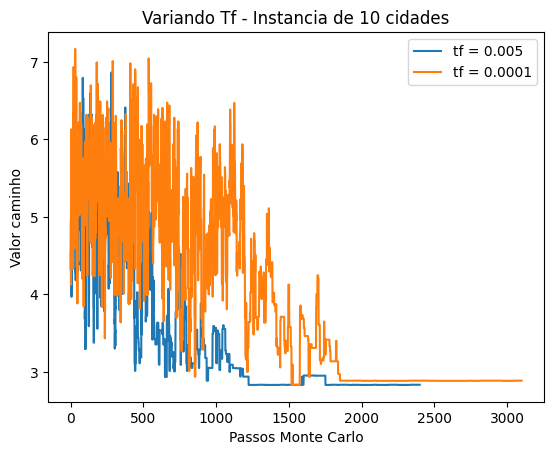

In [19]:
print_charts(mode="tf_all", instance_siz=10, results=ti_all_results)


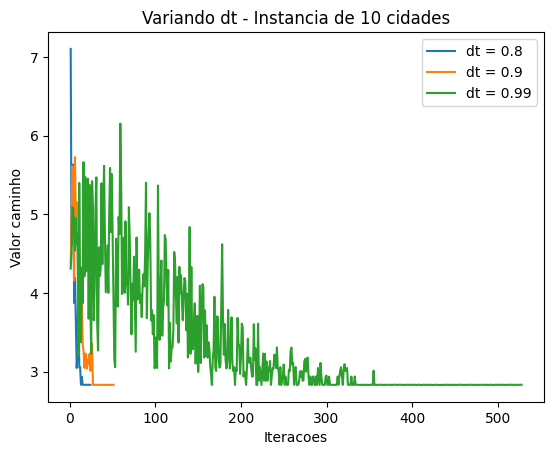

In [25]:
print_charts(mode="dt_it", instance_siz=10, results=dt_it_results)

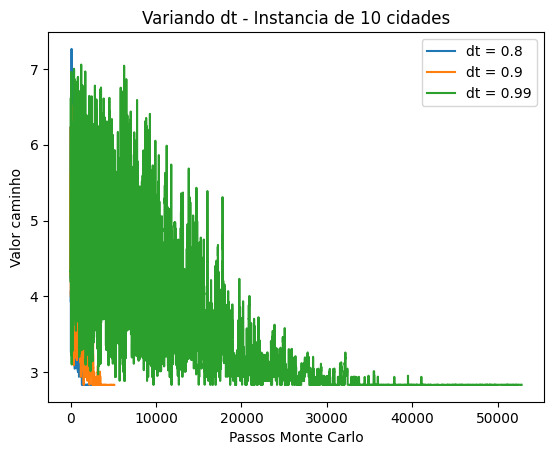

In [23]:
print_charts(mode="dt_all", instance_siz=10, results=dt_all_results)

In [26]:
#Simulating the size-30 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x30, y30, seq30, idx_dict_30)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)


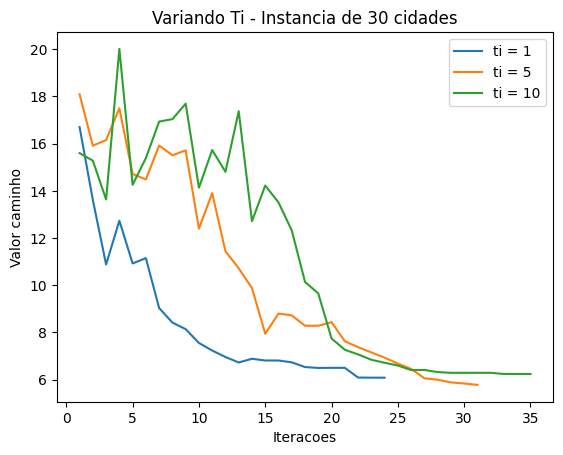

In [33]:
print_charts(mode="ti_it", instance_siz=30, results=ti_it_results)


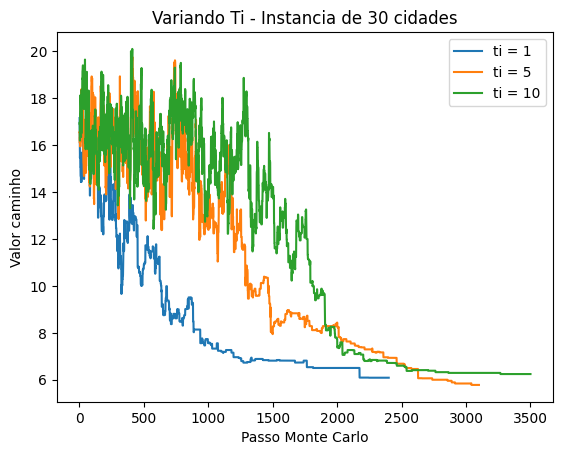

In [34]:
print_charts(mode="ti_all", instance_siz=30, results=ti_all_results)


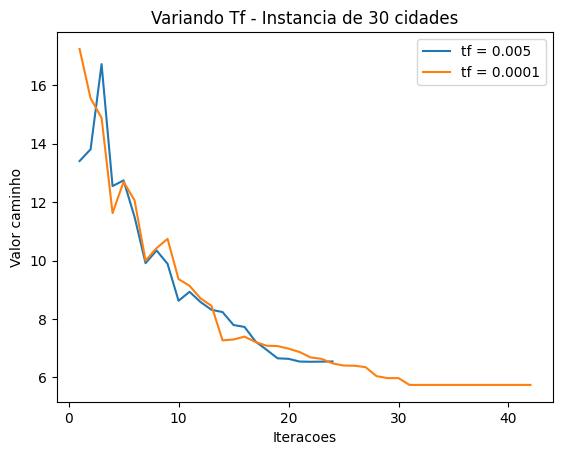

In [35]:
print_charts(mode="tf_it", instance_siz=30, results=tf_it_results)


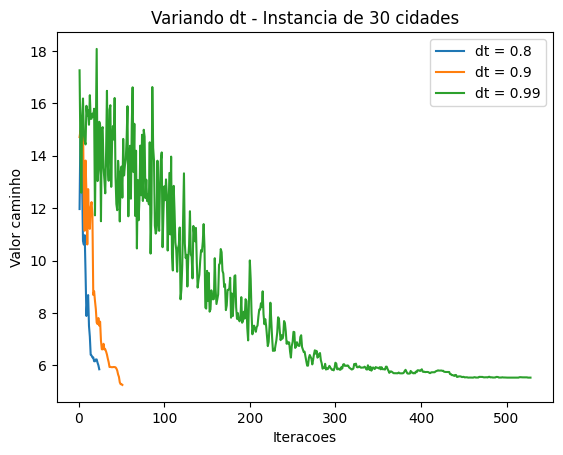

In [36]:
print_charts(mode="dt_it", instance_siz=30, results=dt_it_results)


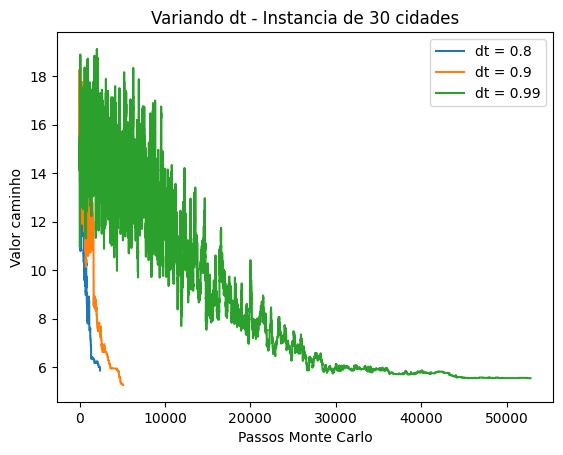

In [37]:
print_charts(mode="dt_all", instance_siz=30, results=dt_all_results)


In [38]:
#Simulating the size-50 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x50, y50, seq50, idx_dict_50)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)


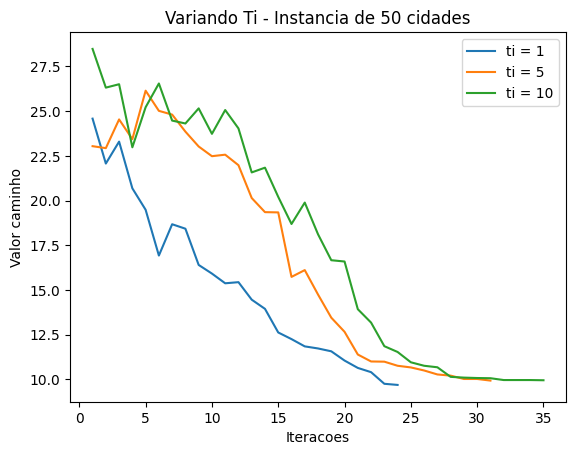

In [39]:
print_charts(mode="ti_it", instance_siz=50, results=ti_it_results)

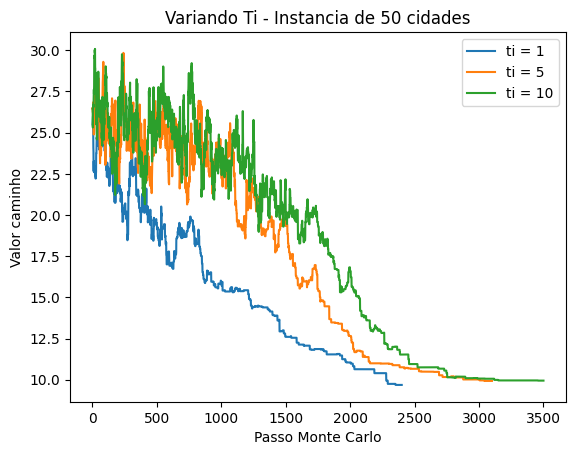

In [40]:
print_charts(mode="ti_all", instance_siz=50, results=ti_all_results)


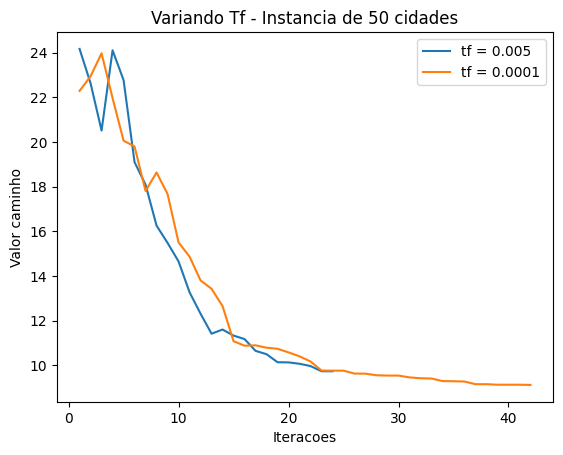

In [41]:
print_charts(mode="tf_it", instance_siz=50, results=tf_it_results)


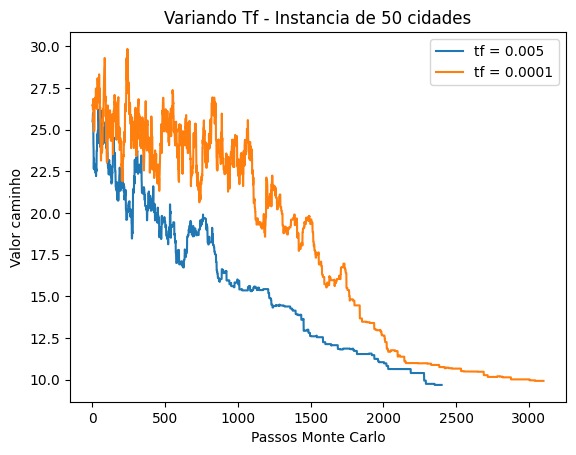

In [42]:
print_charts(mode="tf_all", instance_siz=50, results=ti_all_results)


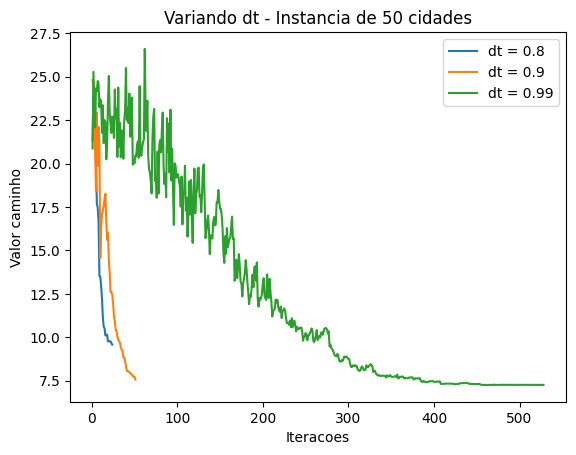

In [43]:
print_charts(mode="dt_it", instance_siz=50, results=dt_it_results)


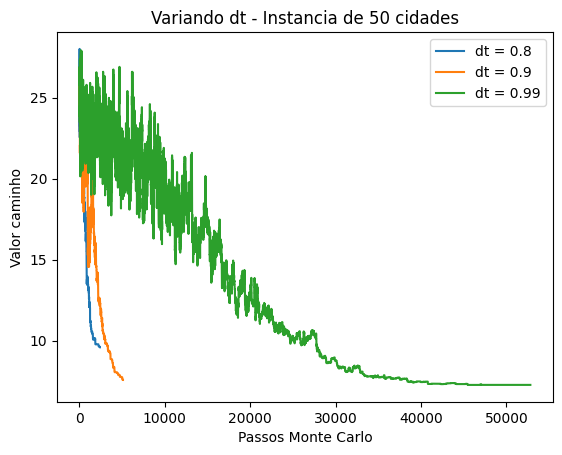

In [44]:
print_charts(mode="dt_all", instance_siz=50, results=dt_all_results)


In [45]:
#Simulating the size-70 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x70, y70, seq70, idx_dict_70)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)


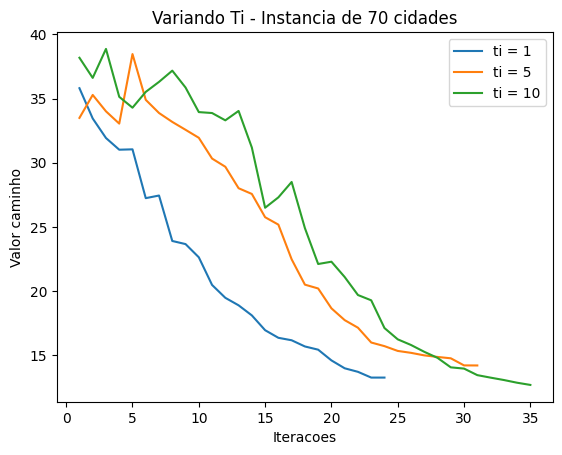

In [46]:
print_charts(mode="ti_it", instance_siz=70, results=ti_it_results)


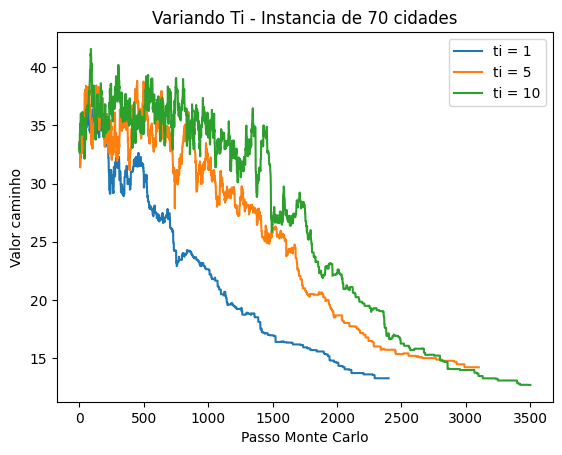

In [47]:
print_charts(mode="ti_all", instance_siz=70, results=ti_all_results)


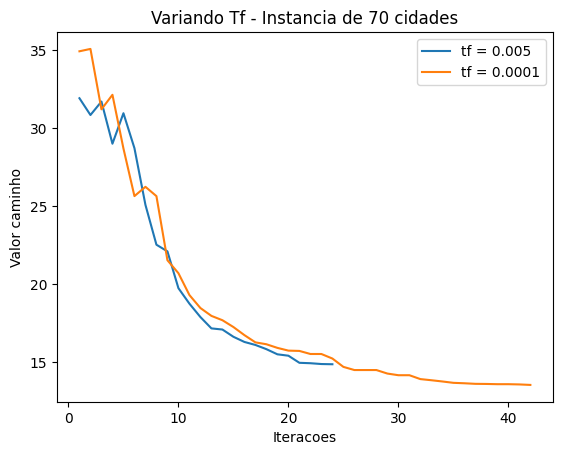

In [48]:
print_charts(mode="tf_it", instance_siz=70, results=tf_it_results)


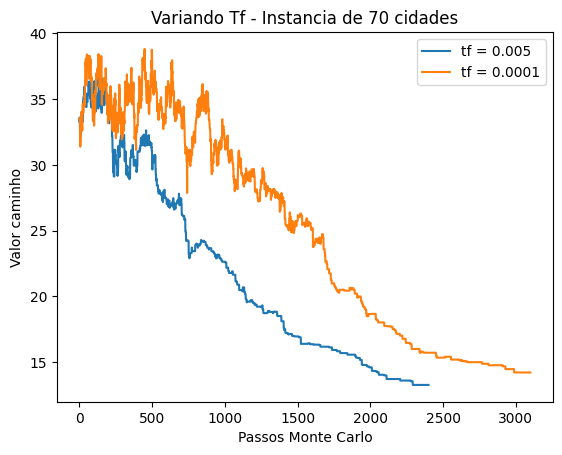

In [49]:
print_charts(mode="tf_all", instance_siz=70, results=ti_all_results)


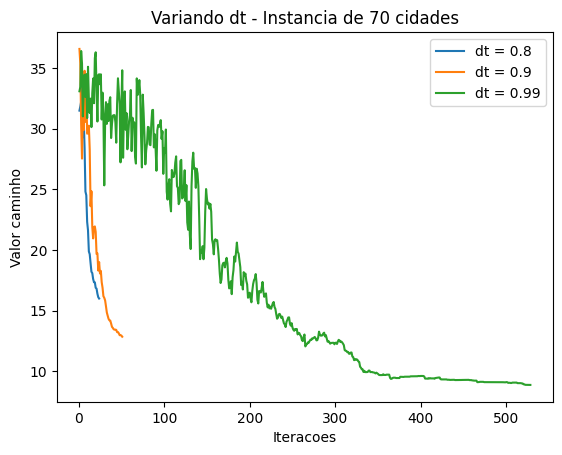

In [50]:
print_charts(mode="dt_it", instance_siz=70, results=dt_it_results)


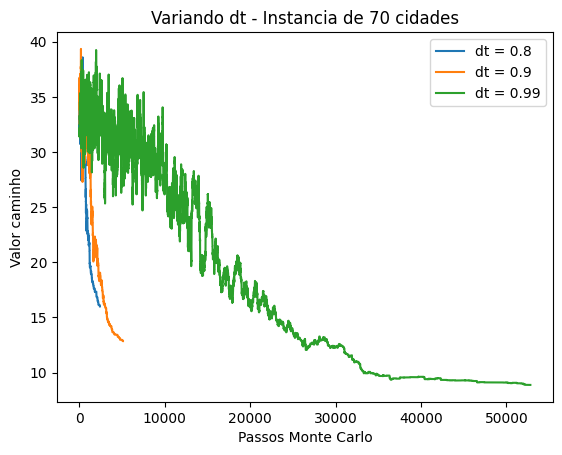

In [51]:
print_charts(mode="dt_all", instance_siz=70, results=dt_all_results)


In [52]:
#Simulating the size-100 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x100, y100, seq100, idx_dict_100)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)
/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in scalar divide
  val = 1 / np.exp(den)


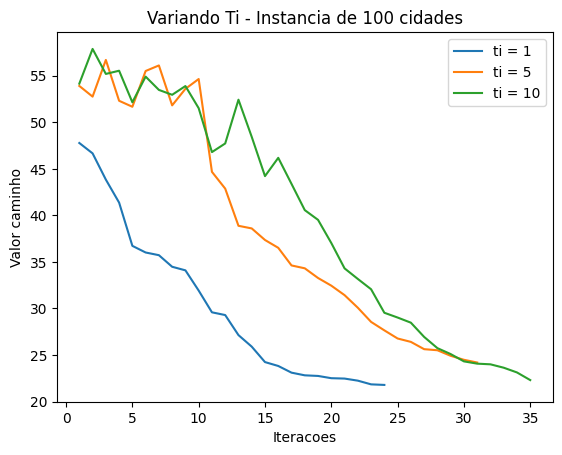

In [53]:
print_charts(mode="ti_it", instance_siz=100, results=ti_it_results)


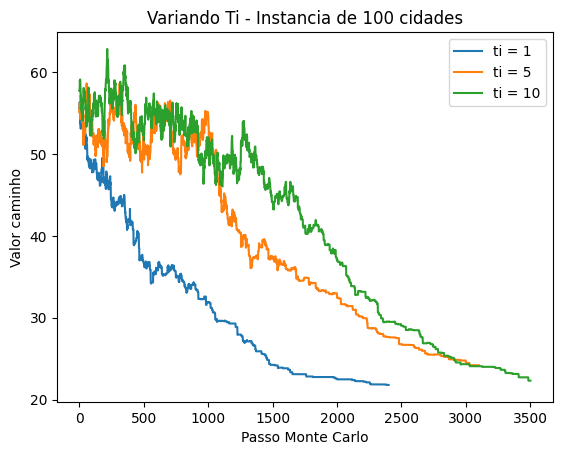

In [54]:
print_charts(mode="ti_all", instance_siz=100, results=ti_all_results)


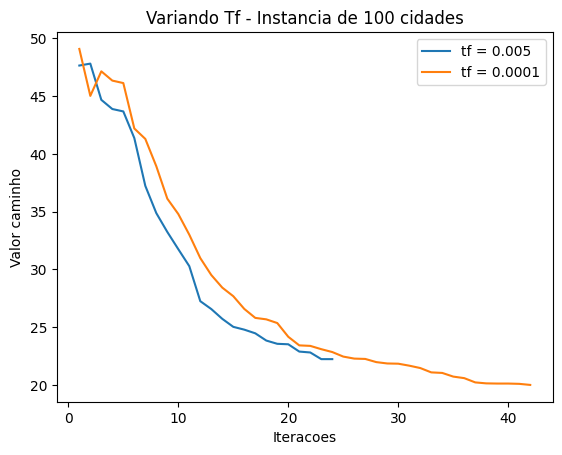

In [55]:
print_charts(mode="tf_it", instance_siz=100, results=tf_it_results)


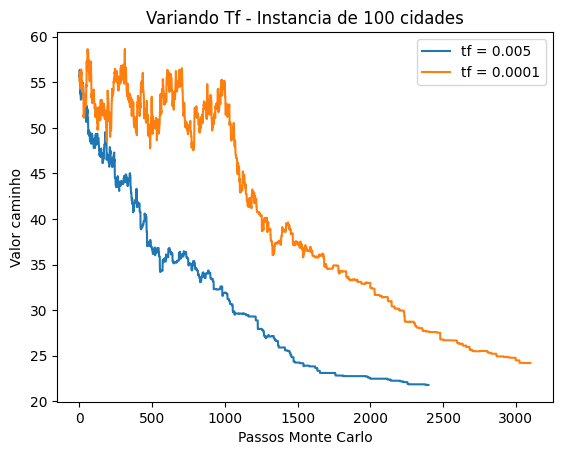

In [56]:
print_charts(mode="tf_all", instance_siz=100, results=ti_all_results)


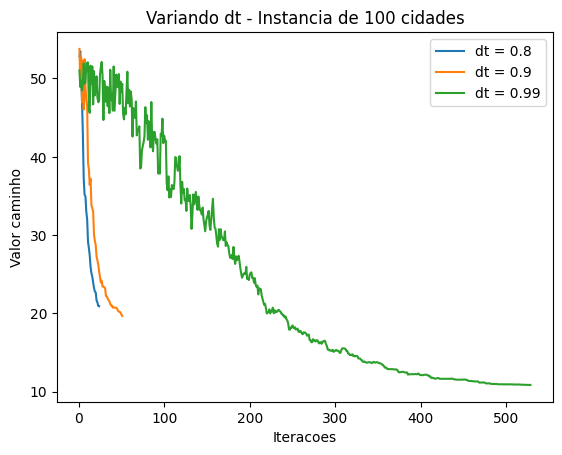

In [57]:
print_charts(mode="dt_it", instance_siz=100, results=dt_it_results)


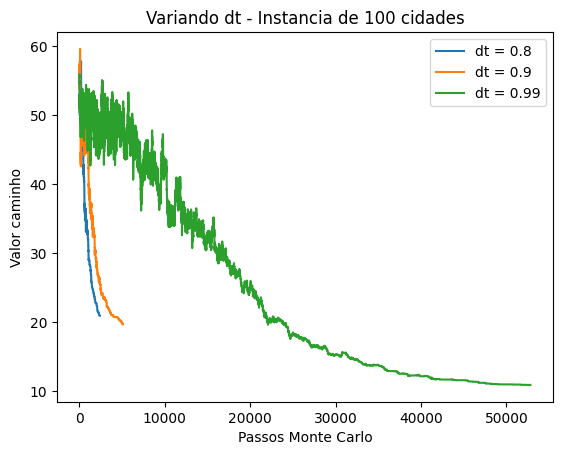

In [58]:
print_charts(mode="dt_all", instance_siz=100, results=dt_all_results)


In [59]:
#Simulating the size-150 instance
clearArrays(ti_it_results, ti_all_results, tf_it_results, tf_all_results, dt_it_results, dt_all_results)
simulate(ti_it_results, tf_it_results, dt_it_results, ti_all_results, tf_all_results, dt_all_results, x150, y150, seq150, idx_dict_150)

/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: overflow encountered in exp
  val = 1 / np.exp(den)
/tmp/ipykernel_14390/1717142188.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1 / np.exp(den)


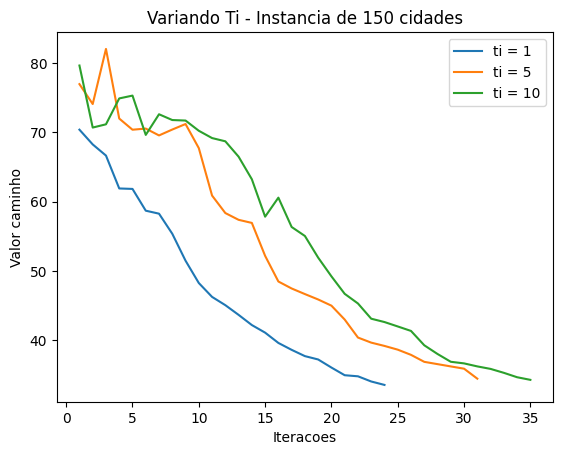

In [60]:
print_charts(mode="ti_it", instance_siz=150, results=ti_it_results)

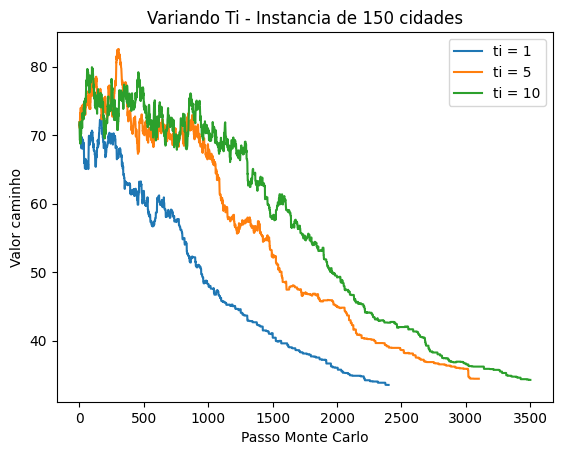

In [61]:
print_charts(mode="ti_all", instance_siz=150, results=ti_all_results)

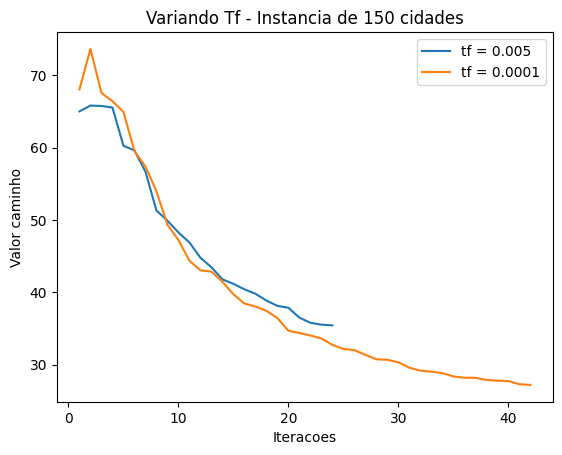

In [62]:
print_charts(mode="tf_it", instance_siz=150, results=tf_it_results)


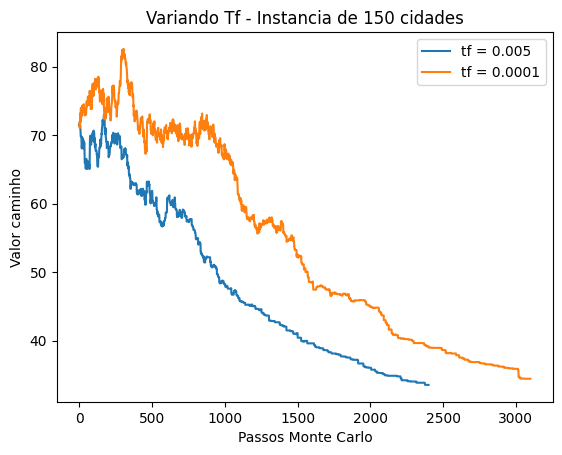

In [63]:
print_charts(mode="tf_all", instance_siz=150, results=ti_all_results)


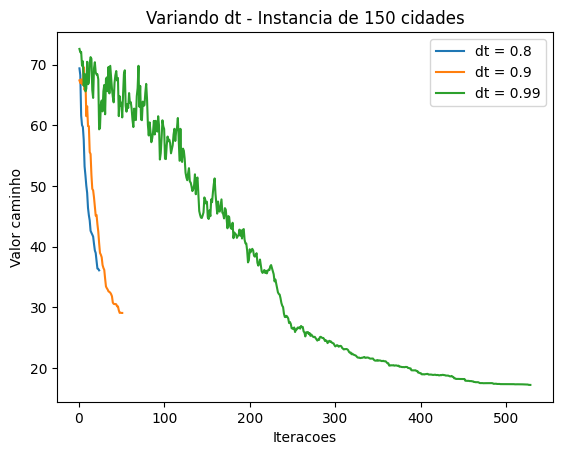

In [64]:
print_charts(mode="dt_it", instance_siz=150, results=dt_it_results)


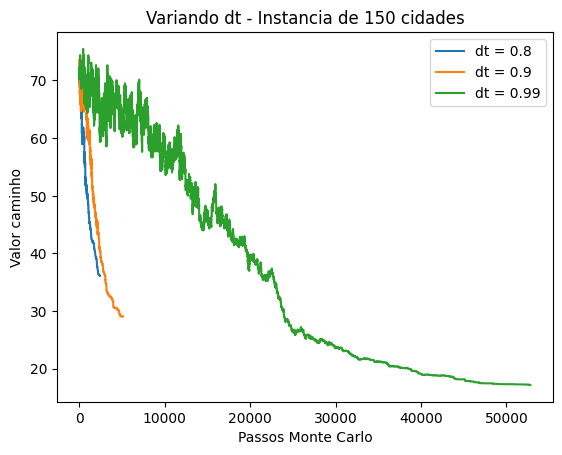

In [65]:
print_charts(mode="dt_all", instance_siz=150, results=dt_all_results)
